<h1 style="text-align:center">DataSet Description</h1>

Main purpose of this data is to explore data-set, 

1. pkl files (Pickle) 
2. meta.csv



## Description

KneeMRI dataset was gathered retrospectively from exam records made on a Siemens Avanto 1.5T MR scanner, and obtained by proton density-weighted fat suppression technique at the Clinical Hospital Centre Rijeka, Croatia, from 2006 until 2014. The dataset consists of 917 12-bit grayscale volumes of either left or right knees. Each volume record was assigned a diagnosis concerning the condition of the anterior cruciate ligament in a double-blind fashion, i.e. each volume record was labelled according to the ligament condition: (1) healthy, (2) partially injured, or (3) completely ruptured. A wider rectangular region of interest (ROI) was manually extracted from the original volumes and is also annotated. For more details regarding the dataset, the reader is referred to the paper stated under the "acknowledging source" section of this webpage.

This dataset was built with the intention of providing scientists, involved with machine vision and/or machine learning, an easy way of working with the data.

## Anterior Cruciate Ligament (ACL) tears

In this project, we will specifically focus on Anterior Cruciate Ligament (ACL) tears which are the most common knee injuries among top athletes in soccer or basketball.
ACL tears happen when the anterior cruciate ligament is either stretched, partially torn, or completely torn. The most common injury is a complete tear.
Symptoms include pain, a popping sound during injury, instability of the knee, and joint swelling.
There are around 200,000 ACL tears each year in the United States, with over 100,000 ACL reconstruction surgeries per year.

## Magnetic Resonance Imaging

Magnetic Resonance Imaging (MRI) is a medical imaging technique used in radiology to form a picture of the anatomy and the physiological processes of the body.
MRI is used to diagnose how well you responded to treatment as well as detecting tears and structural problems such as heart attacks, brain injury, blood vessel damage, etc.

## Some considerations about the data 🤔
1. The slices are significantly different from a plane to another: this is the first thing I noticed as a non-specialist
2. Within a given plane, the slices may substantially differ as well. In fact, and we’ll see it later, some slices can better highlight an ACL tear
3. In the next post, we’ll build an MRI tear classification per plane. We’ll see next that the combination of these three models outperforms individual models
4. An MRI scan taken according to a given plane can be considered as a volume of stacked slices. As we previously said that cases don’t necessarily share the same of slices, MRIs cannot then be put in batches. We’ll see how to handle this efficiently.



## File Attributes

READ.ME         - file contains some basic information regarding this archive
example.py      - Python script used to demonstrate how to access the files
metadata.csv    - comma-delimited (csv) data containing descriptions of distinct volumes (header attribute information included)
volumetric_data - directory containing all knee MR volumes, archived using 7-zip lossless file compression
|-example.pck   - an example Python .pck file (just to inspect whether one wants to be bothered downloading the archive)
|-vol01.7z      - compressed independent archive (1/10), containing 92 cases
|-vol02.7z      - compressed independent archive (2/10), containing 92 cases
|...
|-vol10.7z      - compressed independent archive (10/10), containing the remaining 89 cases


## Columns Description

1. **aclDiagnosis:**  The Lachman test is the most accurate test for detecting an ACL tear. Magnetic resonance imaging is the primary study used to diagnose ACL injury in the United States. It can also identify concomitant meniscal injury, collateral ligament tear, and bone contusions
    * Healthy
    * Half-Ruptured
    * Fully-Ruptured
    

2. **KneeLR:** Means if its left or right

## ACKNOWLEDGING SOURCES:
If you are using this dataset in your work, please acknowledge the source (Clinical Hospital Centre Rijeka, Croatia) and reference this paper (preprint pdf):

I. Štajduhar, M. Mamula, D. Miletić, G. Unal, Semi-automated detection of anterior cruciate ligament injury from MRI, Computer Methods and Programs in Biomedicine, Volume 140, 2017, Pages 151–164.




![Knee Image](extras/knee_2.jpeg)

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
import matplotlib.patches as patch
from IPython.display import HTML
import pickle
import numpy as np
import os
from PIL import Image, ImageDraw
import pandas as pd

import glob


# Data Filteration:

Getting only image which are persent in dataset

In [2]:
# Dataset Dir Path (Image samples)
volumetric_data_dir = 'dataset/kaggle_dataset/'

# Csv Path
metadata_csv_path = 'dataset/kaggle_dataset/metadata.csv'
metadata = pd.read_csv(metadata_csv_path)

# Getting the paths which are available
exists = []
for index in range(len(metadata)):
    
    try:
        path = volumetric_data_dir + "*/" + metadata['volumeFilename'].iloc[index]
        vol_data_file = glob.glob(path)[0]
        exists.append(vol_data_file)
    except IndexError:
        exists.append("not_exists")
metadata['Image_existance'] = exists   
metadata = metadata[metadata['Image_existance'] != 'not_exists']

# Displaying Data in the form of Gif

![Knee Image](extras/knee_1.png)

dataset/kaggle_dataset/*/760062-5.pck

Shape of volume "dataset/kaggle_dataset/vol06/760062-5.pck": (28, 320, 320)
Knee MRI Condition : 0


dataset/kaggle_dataset/*/549957-6.pck

Shape of volume "dataset/kaggle_dataset/vol02/549957-6.pck": (30, 320, 320)
Knee MRI Condition : 1


dataset/kaggle_dataset/*/463773-8.pck

Shape of volume "dataset/kaggle_dataset/vol01/463773-8.pck": (32, 320, 320)
Knee MRI Condition : 2


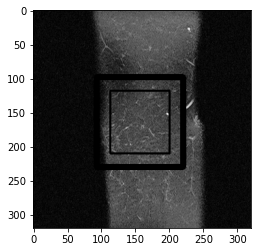

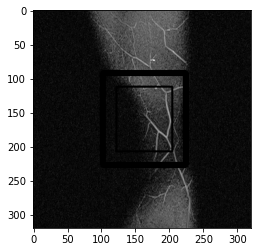

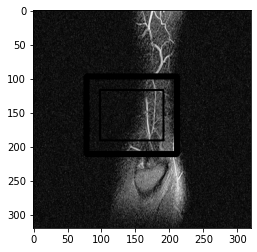

In [3]:
import cv2
import glob
from IPython.display import Javascript, display



# Selecting one sample from
#     1. Healthy
#     2. Half-ruptured
#     3. Fully-ruptured
healthy = metadata[metadata['aclDiagnosis'] == 0].sample()[:1]
half_ruptured = metadata[metadata['aclDiagnosis'] == 1].sample()[:1]
fully_ruptured = metadata[metadata['aclDiagnosis'] == 2].sample()[:1]

frames = [healthy, half_ruptured, fully_ruptured]
example_object = pd.concat(frames)

isClosed = True
  # Green color in BGR
color = (0, 255, 0)
  
# Line thickness of 8 px
thickness = 8



for index in range(len(example_object)):
    
    
    
    # Reading data from DataFrame
    path = volumetric_data_dir + "*/" + example_object['volumeFilename'].iloc[index]
    print(path)
    vol_data_file = glob.glob(path)[0]
    
    # Load data from file
    with open(vol_data_file, 'rb') as file_handler: # Must use 'rb' as the data is binary
        volumetric_data = pickle.load(file_handler)

    print('\nShape of volume "%s":' % vol_data_file, volumetric_data.shape)
    figure = plt.figure()
    
    print(f"Knee MRI Condition : {example_object['aclDiagnosis'].iloc[index]}")
    
    images = []
    for i in volumetric_data:

        # Get roi dimensions
        x, y, w, h = [example_object[attr].iloc[index] for attr in ['roiX', 'roiY', 'roiWidth', 'roiHeight']]
        
        # Rect Points
        i = cv2.rectangle(i, (x, y), (x+w, y+h), (0,0,0), 2)
        
        #Polygon Points
        padding = 20
        pts = np.asarray([
            [x - padding, y - padding],
            [x - padding, (y+h) + padding],
            [(x+w) + padding, (y+h) + padding],
            [(x+w) + padding, y - padding],
            
        ]).reshape((-1, 1, 2))
        
        # Draw polylines
        i = cv2.polylines(i, [pts], 
                      True, (0,0,0), 
                      8)
        
        
        images.append([plt.imshow(i, cmap=cm.Greys_r,animated=True)])




    # Making Annimation of volumetric Medical Data
    ani = animation.ArtistAnimation(figure, images, interval=100, blit=True,
                                    repeat_delay=1000)

    # Displaying Data in the form of fig
    display(HTML(ani.to_html5_video()))



## Conversion  to MRCNN Format

    {
        "Image_name": {
            "filename": "Image_name",
            "file_attributes": {},
            "regions": [
                {
                    "region_attributes": {
                        "class": 1
                    },
                    "shape_attributes": {
                        "name": "polygon",
                        "all_points_x": [],
                        "all_points_y":[]
                    }
                }]
        }
    }
     


In [14]:
import random
import json
from tqdm import tqdm




def convert_to_mrcnn_format(df, make_dataset_here, subset):
    '''
    
    Description:
        Converting Simple Roi's to Mask-Rcnn Format 
        
        
    Inputs:
        df              (pd.DataFrame)  : Pandas DataFrame
        make_dataste    (str)           : String of path to store
        subset          (str)           : Subset If its belong to (Train) (val)
    
    
    Outputs:
        Save json and images in directory
    
    
    '''
    
    
    all_objects = dict()
    save_here = f"{make_dataset_here}{subset}"
    
    os.system(f"rm -rf {save_here}")
    try:
        os.mkdir(save_here)
    except:
        pass
    
    for df_index in tqdm(range(len(df))):

        # Image Name
        path = volumetric_data_dir + "*/" + df['volumeFilename'].iloc[df_index]
        vol_data_file = glob.glob(path)[0]
        image_name_ = vol_data_file.rsplit("/",1)[1].rsplit(".", 1)[0]

        # ROIS (Polygons)
        x, y, w, h = [df[attr].iloc[df_index] for attr in ['roiX', 'roiY', 'roiWidth', 'roiHeight']]


        #Polygon Points
        padding = 20
        pts = np.asarray([
                [x - padding, y - padding],
                [x - padding, (y+h) + padding],
                [(x+w) + padding, (y+h) + padding],
                [(x+w) + padding, y - padding],

            ])


        # Getting the x and y
        x, y =[i for i in zip(*list(pts))]


        # Load pickle object
        with open(vol_data_file, 'rb') as file_handler: # Must use 'rb' as the data is binary
            volumetric_data = pickle.load(file_handler)

        # converting pickle object to images
        remove_images = 3
        for index, image in enumerate(volumetric_data[remove_images : len(volumetric_data) - remove_images]):

            #saving Image
            image_name = f"{image_name_}_{index}.jpg"
            plt.imsave( f"{save_here}/{image_name}", image)
            
            
            # Making the Object dict for training
            object_dict =     {
                                f"{image_name}": {
                                    "filename": f"{image_name}",
                                    "file_attributes": {},
                                    "regions": [
                                        {
                                            "region_attributes": {
                                                "class": 1
                                            },
                                            "shape_attributes": {
                                                "name": "polygon",
                                                "all_points_x": [int(i) for i in x],
                                                "all_points_y": [int(i) for i in y]
                                            }
                                        }]
                                }
                            }
            
            
            
            all_objects.update(object_dict)
    
    with open(f'{save_here}/via_region_data.json', 'w') as fp:
        json.dump(all_objects, fp)
            
    return all_objects
     

In [16]:
make_dataset_here = "dataset/mrcnn_format/"
subset = "train"
train_split = int(0.7 * len(metadata))
val_split = int(train_split * 0.1)





json_format = convert_to_mrcnn_format(metadata[:train_split], make_dataset_here, "train")
json_format = convert_to_mrcnn_format(metadata[train_split: (train_split + val_split)], make_dataset_here, "test")
json_format = convert_to_mrcnn_format(metadata[(train_split + val_split):], make_dataset_here, "val")


# Now go on this path for your mrcnn Training
# 3_train/Train.ipynb

100%|██████████| 170/170 [00:19<00:00,  8.89it/s]


# Unet Format

1. Unet Need Image and its respective mask

In [20]:
import random
import json
from tqdm import tqdm




def convert_to_unet_format(df, make_dataset_here, subset):
    '''
    
    Description:
        Converting Simple Roi's to Mask-Rcnn Format 
        
        
    Inputs:
        df              (pd.DataFrame)  : Pandas DataFrame
        make_dataste    (str)           : String of path to store
        subset          (str)           : Subset If its belong to (Train) (val)
    
    
    Outputs:
        Save json and images in directory
    
    
    '''
    
    
    all_objects = dict()
    save_images = f"{make_dataset_here}{subset}/images/"
    save_masks = f"{make_dataset_here}{subset}/masks/"
    
    os.system(f"rm -rf {save_images}")
    os.system(f"rm -rf {save_masks}")
    try:
        os.mkdir(save_images)
        os.mkdir(save_masks)
    except:
        pass
    
    for df_index in tqdm(range(len(df))):

        # Image Name
        path = volumetric_data_dir + "*/" + df['volumeFilename'].iloc[df_index]
        vol_data_file = glob.glob(path)[0]
        image_name_ = vol_data_file.rsplit("/",1)[1].rsplit(".", 1)[0]

        # ROIS (Polygons)
        x, y, w, h = [df[attr].iloc[df_index] for attr in ['roiX', 'roiY', 'roiWidth', 'roiHeight']]


        #Polygon Points
        padding = 20
        pts = np.asarray([
                [x - padding, y - padding],
                [x - padding, (y+h) + padding],
                [(x+w) + padding, (y+h) + padding],
                [(x+w) + padding, y - padding],

            ])


        # Getting the x and y
        x, y =[i for i in zip(*list(pts))]


        # Load pickle object
        with open(vol_data_file, 'rb') as file_handler: # Must use 'rb' as the data is binary
            volumetric_data = pickle.load(file_handler)

        # converting pickle object to images
        remove_images = 5
        for index, image in enumerate(volumetric_data[remove_images : len(volumetric_data) - remove_images]):

            # Saving Image
            image_name = f"{image_name_}_{index}.jpg"
            mask_name = f"{image_name_}_{index}.jpg"
            
            
            

  

            pts = [tuple(i) for i in pts]
  
            img = Image.new("RGB", (image.shape[1], image.shape[0]), "#000000") 
            img1 = ImageDraw.Draw(img)  
            img1.polygon(pts, fill ="#FFFFFF") 

            # Save Image here
            plt.imsave( f"{save_images}/{image_name}", image)
            
            # Save Mask here
            img.save( f"{save_masks}/{image_name}")
            
            

     

In [21]:
make_dataset_here = "dataset/unet_format/"
subset = "train"
train_split = int(0.7 * len(metadata))
val_split = int(train_split * 0.1)





json_format = convert_to_unet_format(metadata[:train_split], make_dataset_here, "train")
json_format = convert_to_unet_format(metadata[train_split: (train_split + val_split)], make_dataset_here, "test")
json_format = convert_to_unet_format(metadata[(train_split + val_split):], make_dataset_here, "val")

100%|██████████| 170/170 [00:20<00:00,  8.13it/s]
